---
layout: page
title: Retirement Burndown
---

## How much do I need to retire?

This page plots a retirement fund portfolio for different lifestyle scenarios. 

In [7]:
import sys
sys.path.insert(0, '../src')
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from IPython.display import display, Markdown

Annual retirement expenses are based on data from the [Association of Superannuation Funds of Australia](retirement-planning.md). Expenses are plotted for different 'lifestyle' models:

In [8]:
""" Chart variables """
# annual expenses source retirement-planning.md
# this is also simplified - expenses typically reduce after age 85 when most people have a less active lifestyle.
annual_expenses = {
    "modest": 45000,
    "comfortable": 70000,
    "four-star": 90000,
    "luxury": 140000,
    "opulent": 230000,
}

# Create a Markdown table
table = "| " + " | ".join(annual_expenses.keys()) + " |\n"
table += "| " + " | ".join("--:" for _ in annual_expenses.keys()) + " |\n"
table += "| " + " | ".join("${:,}".format(value) for value in annual_expenses.values()) + " |"

# Display the table
display(Markdown(table))

| modest | comfortable | four-star | luxury | opulent |
| --: | --: | --: | --: | --: |
| $45,000 | $70,000 | $90,000 | $140,000 | $230,000 |

In [9]:
life_expectancy = 100
retirement_age = 50 
retirement_years = life_expectancy - retirement_age + 1 # add 1 to include year of retirement in range

display(Markdown(f"""
Assume I desire a fund to cover a life expectancy to {life_expectancy} years.
How much would I need from age {retirement_age} to {life_expectancy}?
"""))


Assume I desire a fund to cover a life expectancy to 100 years.
How much would I need from age 50 to 100?


In [10]:
""" Data manipulation """

# Create a DataFrame with number of rows = retirement_years
df = pd.DataFrame(index=range(retirement_years))

# For each key in annual_expenses, create a column
for lifestyle, expense in annual_expenses.items():
    # Each year the values increase by the related annual_expenses value
    df[lifestyle] = [i * expense for i in range(retirement_years)]
    df['year'] = retirement_years - df.index
    df['age'] = life_expectancy - df.index

# Create a new dataframe with age as the index
df_age = df.set_index('age')


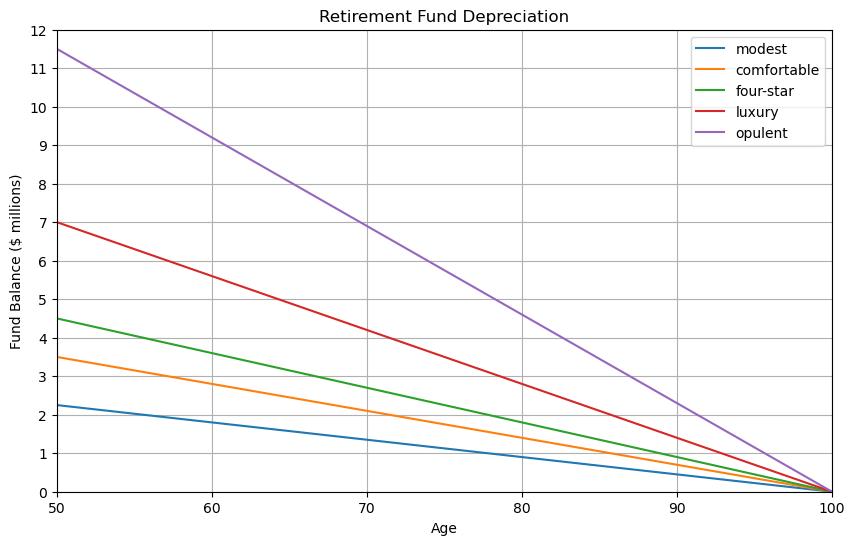

In [11]:
""" Basic chart """
df_expenses = df_age[list(annual_expenses.keys())]
df_expenses.plot(figsize=(10, 6))
plt.xlabel('Age')
plt.ylabel('Fund Balance ($ millions)')
plt.title('Retirement Fund Depreciation')
plt.grid(True)
plt.xlim([retirement_age, life_expectancy])
plt.ylim(ymin=0, ymax=12e6)

# Format y-axis ticks every 1 million with integer labels
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e6))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x*1e-6)))

plt.show()

This model excludes inflation, the true funds required would be much higher as expenses increase over time.

This model also assumes a cash fund that excludes interest, yield or appreciation. The funds required would go further if the fund earnt value over time.